# 自动求导的相关设置

- Tensor的属性：
    - requires_grad=True
        - 是否用来求导
    - is_leaf：
        - 叶子节点必须是计算的结果；
            - 用户创建的Tensor的is_leaf=True（尽管requires_grad=True，也is_leaf=True）；
            - requires_grad=False的Tensor的is_leaf=True；
    - grad_fn：
        - 用来指定求导函数；
    - grad
        - 用来返回导数；
    - dtype
        - 只有torch.float的张量才能求导；

1. 求导的例子

In [1]:
import torch


# x自变量
x = torch.Tensor([5])
x.requires_grad=True

# y因变量
y = x ** 2

# 求导
y.backward()

# 导数的结果
print(x.grad)


tensor([10.])


2. 求导的可视化(导数函数的曲线)

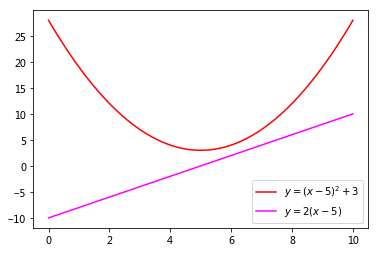

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch


# x自变量
x = torch.linspace(0, 10, 100)
x.requires_grad=True

# y因变量
y = (x - 5) ** 2 + 3
z = y.sum()
# 求导
z.backward()

print()
# 可视化
plt.plot(x.detach(), y.detach(), color=(1, 0, 0, 1), label='$y=(x-5)^2 + 3$')
plt.plot(x.detach(), x.grad.detach(), color=(1, 0, 1, 1), label='$y=2(x-5)$')
plt.legend()
plt.show()

# print(x.grad)
# print(x)

3. 求导相关的属性值

In [3]:
import torch


# x自变量
x = torch.Tensor([5])
x.requires_grad=True

# 求导前的属性
print("-------------求导前x")
print("leaf:", x.is_leaf)
print("grad_fn:", x.grad_fn)
print("grad:", x.grad)
# y因变量
y = x ** 2
print("-------------求导前y")
print("requires_grad:", y.requires_grad)
print("leaf:", y.is_leaf)
print("grad_fn:", y.grad_fn)
print("grad:", y.grad)
# 求导
y.backward()    # 只对标量运算

print("-------------求导后x")
# 求导后的属性
print("leaf:", x.is_leaf)
print("grad_fn:", x.grad_fn)
print("grad:", x.grad)
print("-------------求导后y")
print("requires_grad:", y.requires_grad)
print("leaf:", y.is_leaf)
print("grad_fn:", y.grad_fn)
print("grad:", y.grad)

-------------求导前x
leaf: True
grad_fn: None
grad: None
-------------求导前y
requires_grad: True
leaf: False
grad_fn: <PowBackward0 object at 0x11ee90cf8>
grad: None
-------------求导后x
leaf: True
grad_fn: None
grad: tensor([10.])
-------------求导后y
requires_grad: True
leaf: False
grad_fn: <PowBackward0 object at 0x11ee90828>
grad: None


# Tensor的backward函数

## backward函数定义

- 函数定义：
```python
    backward(self, gradient=None, retain_graph=None, create_graph=False)
```

- 参数说明：
    - gradient=None：需要求导的微分张量；
    - retain_graph=None：保留图；否则每次计算完毕，床创建的图都会被释放。
    - create_graph=False：创建导数图，主要用来求高阶导数；

## 求导的通用模式

- 函数表达式：
    - $z =  2x + 3y$
- 手工求导：
    - $\dfrac{\partial{z}}{\partial{x}} = 2$

In [4]:
import torch

x = torch.Tensor([1, 2, 3])
x.requires_grad=True         # 这个属性必须在 z = 2*x + 3*y 表达式构建图的时候设置

y = torch.Tensor([4, 5, 6])

z = 2*x + 3*y

z.backward(x)     # 对x求导，得到的结果，自然是 2，但是x的grad是 2 * x 

print(x.grad, y.grad, z.grad)    # 没有对y求导，所以对y没有要求


tensor([2., 4., 6.]) None None


## 理解导数
 
- 函数表达式：
    - $z =  x^2$
- 手工求导：
    - $\dfrac{\partial{z}}{\partial{x}} = 2x$

-  $\color{red}{上面过程怎么计算的呢？}$

### 结果张量为标量的情况
- 如果z是标量，则直接计算导数：$\dfrac{\partial{z}}{\partial{x}} = 2x$

In [5]:
import torch

x = torch.Tensor([2])
x.requires_grad=True         
z = x**2                # 求导函数
z.backward()     # 对x求导，2 * x    ，导数为2x=4
print(x.grad, z.grad)    

tensor([4.]) None


### 结果张量为向量的情况

- 如果z是向量，则需要先计算z与x的内积，得到标量结果，然后再求导。
    - $z =  x^2$
    - $l = z \cdot x$
    - $\dfrac{\partial{l}}{\partial{x}} = \dfrac{\partial{l}}{\partial{z}} \dfrac{\partial{z}}{\partial{x}} = x \dfrac{\partial{z}}{\partial{x}} = x 2x$

In [6]:
import torch

x = torch.Tensor([2])
x.requires_grad=True         
y = x**2               # 求导函数

y.backward(x)     # 2 x x = 8

print(x.grad, y.grad)    
print(x.grad/x)    # 正宗结果    

tensor([8.]) None
tensor([4.], grad_fn=<DivBackward0>)


### 取求导向量为1向量

- 根据上面的推导，在自动求导中包含几个默认动作：
    - 1. 使用z.backward()，没有指定微分量的情况下，实际上是对图的所有标记为requires_grad=True的叶子张量实现求导；
        - 当叶子节点都是requires_grad=False，会抛出异常。
            - `RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn`
             
    - 2. 使用z.backward(x)，直接指定需要的求导；
        - 其实这种指定，是没有意义的，因为指定x，也是对所有requires_grad=True的叶子节点求导。

- 下面例子体会下，多个叶子节点的自动求导；
    - 就算只对x求导，实际对y也会求导；

In [7]:
import torch

x = torch.Tensor([1, 2, 3])
y = torch.Tensor([4, 5, 6])

x.requires_grad=True  
y.requires_grad=True  

z = 3*x + 2*y                # 求导函数

z.backward(x)      # 对x求导

print(x.grad,  y.grad)  # [3., 6., 9.] ：导数是3  与 [2., 4., 6.]：导数是2

print(x.grad/x,  y.grad/x)  # [3., 6., 9.] ：导数是3  与 [2., 4., 6.]：导数是2

tensor([3., 6., 9.]) tensor([2., 4., 6.])
tensor([3., 3., 3.], grad_fn=<DivBackward0>) tensor([2., 2., 2.], grad_fn=<DivBackward0>)


- 从上面例子看出：backward的参数张量，仅仅是把求导函数从向量转换成标量求导， 本身并没有指定对哪个变量（张量求导的）的含义。
    - 由于backward的参数仅仅是向量到变量的转化工作，所以我们去这个参数为1即可。下面是推理理论。

- $z =  x^2$
- $l = z \cdot 1$
- $\dfrac{\partial{l}}{\partial{x}} = \dfrac{\partial{l}}{\partial{z}} \dfrac{\partial{z}}{\partial{x}}  =  \dfrac{\partial{z \cdot 1 }}{\partial{z}} \dfrac{\partial{z}}{\partial{x}}  = \dfrac{\partial{z}}{\partial{x}} = 2x$

- 取1张量作为梯度求导

In [8]:
import torch

x = torch.Tensor([1, 2, 3])
x.requires_grad=True         
z = x**2                # 求导函数
z.backward(torch.ones_like(x)) 
print(x.grad, z.grad)    

tensor([2., 4., 6.]) None


- 下面的操作与取1张量的原理完全一致
    - 只是用户自己做了这个内积运算而已。

In [9]:
import torch

x = torch.Tensor([1, 2, 3])
x.requires_grad=True         
z = (x**2).sum()                # 直接求和

z.backward() 
print(x.grad, z.grad)    

tensor([2., 4., 6.]) None


## 复杂的求导运算例子
- 下面是计算的图示意图：
    - 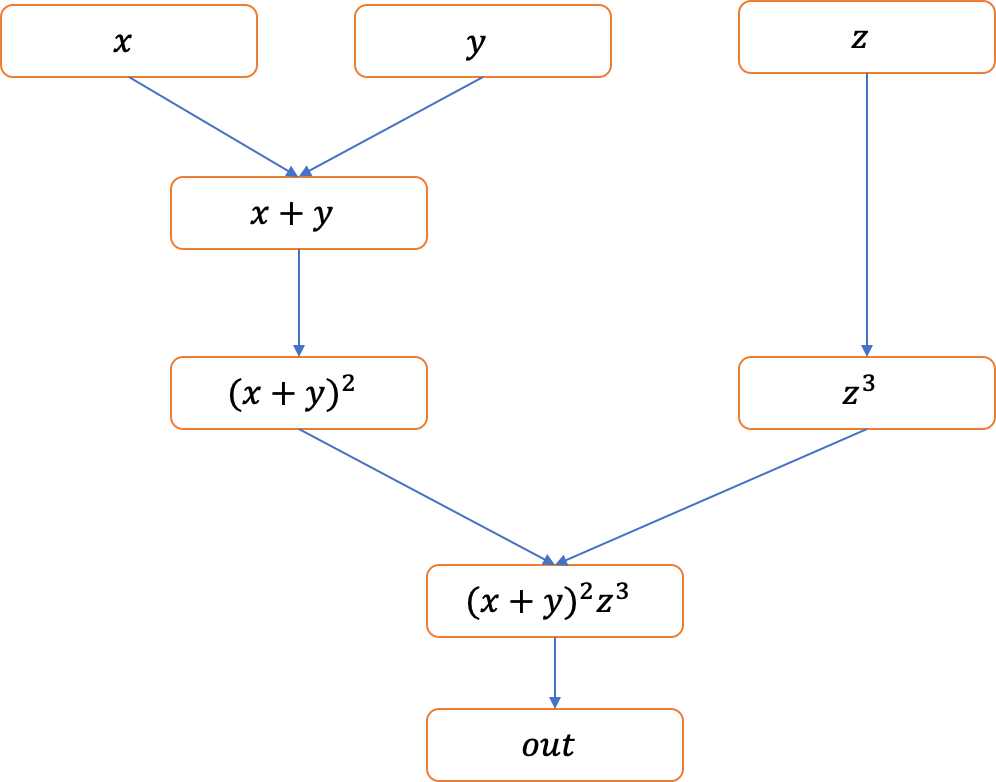

In [14]:
import torch

#  叶子节点

x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])

x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

# 中间节点
xy = x + y
xy2 = xy ** 2
z3 = z ** 3
xy2z3=xy2 * z3

# 求导数
xy2z3.backward(torch.Tensor([1.0, 1.0, 1.0]))
print(x.grad, y.grad, z.grad)
print(xy.grad, xy2.grad, z3.grad, xy2z3.grad)      # 没有梯度，因为不是叶子节点
print(xy.grad_fn, xy2.grad_fn, z3.grad_fn, xy2z3.grad_fn)
print(xy.requires_grad, xy2.requires_grad, z3.requires_grad, xy2z3.requires_grad)

tensor([  8.,  96., 432.]) tensor([  8.,  96., 432.]) tensor([  48.,  432., 1728.])
None None None None
<AddBackward0 object at 0x11efe69e8> <PowBackward0 object at 0x11efe6940> <PowBackward0 object at 0x11efe6a90> <MulBackward0 object at 0x11efe6ac8>
True True True True


## 中间导数

- 使用上面模式编程，可以发现其中只计算出输入变量的导数，中间变量的导数是无法获取的，如果想获取中间变量的导数，需要注册一个回调钩子函数，通过这个函数返回。

- 获取中间变量导数的例子

In [40]:
import torch

#  叶子节点
x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])

x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

# 中间节点
xy = x + y
# xyz = xy * z
# xyz.backward(torch.Tensor([1, 1, 1]))

xyz = torch.dot(xy, z)
# ====================
def get_xy_grad(grad):
    print(F"xy的导数：{ grad }")   # 可以保存到全局变量使用。

xy.register_hook(get_xy_grad)

# ====================

xyz.backward()
print(x.grad, y.grad, z.grad)
print(xy.grad, y.grad, z.grad)

xy的导数：tensor([1., 2., 3.])
tensor([1., 2., 3.]) tensor([1., 2., 3.]) tensor([4., 6., 8.])
None tensor([1., 2., 3.]) tensor([4., 6., 8.])


## 高阶导数

1. 提供create_graph参数用来保留导数的图，用来实现高级导数的计算。
2. 高阶导数因为不是叶子节点，需要通过回调钩子获取

In [54]:
import torch

x = torch.Tensor([1])
x.requires_grad=True         
z = x**6               # 求导函数
z.backward(create_graph=True)     # retain_graph保留的是本身的运算图，create_graph是保留微分图
print(x.grad)    # 导数3
# ====================
def get_xy_grad(grad):
    print(F"x.grad的高阶导数：{ grad }")   # 可以保存到全局变量使用。

x.register_hook(get_xy_grad)
# ====================
x.grad.backward(create_graph=True) 



tensor([6.], grad_fn=<CloneBackward>)
x.grad的高阶导数：tensor([30.], grad_fn=<MulBackward0>)


# Tensor的自动求导

- 有了上面的基础，下面看torch.autograd中的自动求导，就基本上非常简单。
- Torch提供了torch.autograd模块来实现自动求导，该模块暴露的调用如下：
    - `['Variable', 'Function', 'backward', 'grad_mode']`

## backward的使用

- autograd提供的backward是Tensor的backward的静态函数版本，使用谈不上便捷，但多了一个选择；
```python
    torch.autograd.backward(
        tensors, 
        grad_tensors=None, 
        retain_graph=None, 
        create_graph=False, 
        grad_variables=None)
```

- 参数说明：
    - tensors：被求导的向量（必须具有grad_fn）；
    - grad_tensors=None：梯度向量；
    - retain_graph=None：保留计算图；
    - create_graph=False：创建个高阶微分图（可以自己手工得到高阶导数，也可以使用下面的grad封装函数）；
    - grad_variables=None：兼容原来Variable版本的参数，在新的版本中不再使用。

- torch.autograd.backward函数的使用例子
    -  参数grad_variables在我的这个版本中，已经不能使用。

In [56]:
import torch

#  叶子节点
x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])

x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

# 中间节点
xy = x + y
# xyz = xy * z
# xyz.backward(torch.Tensor([1, 1, 1]))

xyz = torch.dot(xy, z)
# ====================
def get_xy_grad(grad):
    print(F"xy的导数：{ grad }")   # 可以保存到全局变量使用。

xy.register_hook(get_xy_grad)

# ====================

torch.autograd.backward(xyz)
print(x.grad, y.grad, z.grad)
print(xy.grad, y.grad, z.grad)

xy的导数：tensor([1., 2., 3.])
tensor([1., 2., 3.]) tensor([1., 2., 3.]) tensor([4., 6., 8.])
None tensor([1., 2., 3.]) tensor([4., 6., 8.])


## grad的使用

- 用来计算输出关于输入的梯度的和，不是返回所有的梯度，而是对某个输入变量的求导：$\dfrac{\partial{z}}{\partial{x}}$
- 这个函数的功能应该与hook功能类似。

- grad函数的定义：

```python
    torch.autograd.grad(
        outputs, 
        inputs, 
        grad_outputs=None, 
        retain_graph=None, 
        create_graph=False, 
        only_inputs=True, 
        allow_unused=False)
```

- 参数说明：
    - outputs：输出张量列表，与backward函数中的tensors作用一样；
    - inputs：输入张量列表，用来调用register_hook的张量；
    - grad_outputs：梯度张量列表，与backward函数中的grad_tensors作用一样；
    - retain_graph：逻辑值，用来指定运算完毕是否清除计算图；
    - create_graph：逻辑值，用来创建梯度的计算图（梯度的梯度就是高阶导数）
    - only_inputs：逻辑值，用来指定返回的计算结果，不仅仅是inputs指定的张量，而是计算所有叶子节点的导数。默认值True：这个参数已经不推荐使用，而且已经没有作用了，向计算叶子节点的导数没使用backward函数。
    - allow_unused：逻辑值，用来检测是否每个输入都用来计算输出，False表示不需要，True表示如果有输入没有用于输出计算，则抛出错误。如果没有输入都是用，则True与False结果都一样。默认值False

- grad的使用例子

In [65]:
import torch

#  叶子节点
x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])

x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

# 中间节点
xy = x + y
xyz = torch.dot(xy, z)

# ====================
gd = torch.autograd.grad(xyz, x, retain_graph=True)

print(x.grad, y.grad, z.grad)
print(xy.grad, y.grad, z.grad)
print(gd)
print(torch.autograd.grad(xyz, xy,retain_graph=True))
print(torch.autograd.grad(xyz, y,retain_graph=True))
print(torch.autograd.grad(xyz, z,retain_graph=True, allow_unused=True))
# ====================


None None None
None None None
(tensor([1., 2., 3.]),)
(tensor([1., 2., 3.]),)
(tensor([1., 2., 3.]),)
(tensor([4., 6., 8.]),)


### grad的高阶求导

- 使用create_graph创建导数的图，并对导数再求导，从而实现高阶求导。

In [89]:
import torch

x = torch.Tensor([1])
x.requires_grad=True         
z = x**6               # 求导函数

gd_1 = torch.autograd.grad(z, x, create_graph=True)

gd_2 = torch.autograd.grad(gd_1, x)
print(F"一阶导数：{gd_1},\n二阶导数： {gd_2}")


一阶导数：(tensor([6.], grad_fn=<MulBackward0>),),
二阶导数： (tensor([30.]),)


# 求导的控制

## set_grad_enabled类

- set_grad_enabled函数可以开启与关闭导数计算
    - 一个上下文管理对象

- 函数声明如下：

```python
    torch.autograd.set_grad_enabled(mode)
```

- 参数：
    -  mode：逻辑值，True开启，False关闭

### 通常使用例子

In [71]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

torch.autograd.set_grad_enabled(False)   # 全局上下文
xy = x + y
xyz = torch.dot(xy, z)
torch.autograd.set_grad_enabled(True)


print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

False False True


### 上下文使用例子

In [72]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

with torch.autograd.set_grad_enabled(False)  as grad_ctx:   # 局部上下文
    xy = x + y    # 块结束，作用范围自动结束

xyz = torch.dot(xy, z)
print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

False True True


## enable_grad类

- 这个类是一个装饰器类，提供更加简捷的开启方式。
    - 也是一个上下文管理器；
    - 装饰器用于函数与类；

```python
    
    torch.autograd.enable_grad()

```

### 装饰器使用例子

In [77]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

@ torch.autograd.enable_grad()
def func_xy(x, y):
    return x + y    # 块结束，作用范围自动结束

xy = func_xy(x, y)

xyz = torch.dot(xy, z)
print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

True True True


### 上下文使用例子

In [78]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

with torch.autograd.enable_grad():
    xy = x + y

xyz = torch.dot(xy, z)
print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

True True True


## no_grad类

- 与enable_grad类一样的使用方式，作用却相反。

- 注意：
    - no_grad与enable_grad是函数装饰器，不是类装饰器；

### 装饰器使用方式

- 对整个函数作用，适合函数模式，如果函数中有特殊的情况，可以嵌套使用。

In [80]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

@ torch.autograd.no_grad()
def func_xy(x, y):
    return x + y    # 块结束，作用范围自动结束

xy = func_xy(x, y)

xyz = torch.dot(xy, z)
print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

False True True


### 上下文使用方式

- 适合于在非函数情况下使用

In [82]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

with torch.autograd.no_grad():
    xy = x + y

xyz = torch.dot(xy, z)
print(xy.requires_grad, xyz.requires_grad, z.requires_grad)

False True True


### no_grad与enable_grad混合使用

- 这种混合使用，可以满足开发的任何情况的需求；

In [85]:
import torch


x = torch.Tensor([1, 2, 3]) 
y = torch.Tensor([3, 4, 5]) 
z = torch.Tensor([1, 2, 3])
x.requires_grad=True
y.requires_grad=True
z.requires_grad=True

with torch.autograd.no_grad():
    xy = x + y
    with torch.autograd.enable_grad():
        z3 = z **3
        xy2 = xy ** 2    # 因为xy的requires_grad=False，整个运算也是False
        
print(xy.requires_grad, z3.requires_grad, xy2.requires_grad)

False True False


----